In [2]:
#ライブラリをインポート
import os #OSに依存する様々な機能を利用するためのモジュール(ファイルやディレクトリ操作など)
import re #正規表現を利用するためのモジュール
import csv  #csvファイルを扱うためのモジュール
import math #数学的計算のためのモジュール
import matplotlib.pyplot as plt #グラフ描画のためのモジュール
import numpy as np  #多次元配列計算のためのモジュール
import pandas as pd #データフレームを扱うためのモジュール
from scipy import signal  #信号処理のためのモジュール
from scipy.stats import skew, kurtosis  #歪度と尖度を調べるためのモジュール
from sklearn.model_selection import train_test_split  #データをトレーニング用とテスト用に分けるためのモジュール
from sklearn import preprocessing #データを正規化するためのモジュール
from sklearn.preprocessing import StandardScaler  #データを標準化するためのモジュール
from sklearn.preprocessing import LabelEncoder  #カテゴリ変数を数値化するためのモジュール
from sklearn.linear_model import LinearRegression #線型回帰
from sklearn.svm import SVC #サポートベクターマシン
from sklearn.ensemble import RandomForestClassifier #ランダムフォレスト
from sklearn.neighbors import KNeighborsClassifier  #k-近傍法
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score #機械学習モデルの性能評価のためのモジュール
import xgboost as xgb #XGBoost
import lightgbm as lgb  #LightGBM
import tensorflow as tf #TensorFlow(Googleが開発したオープンソースの機械学習フレームワーク)
from tensorflow import keras  #TensorFlow用のニューラルネットワークライブラリAPI
from tensorflow.keras import layers #ニューラルネットワークのレイヤーを定義するためのモジュール
from keras.utils import plot_model  #モデルをプロットするためのモジュール
import torch  #PyTorch
import torch.nn as nn #ニューラルネットワークのためのモジュール
import torch.optim as optim #パラメータの最適化を行うためのモジュール
from torch.utils.data import DataLoader, Dataset  #データをバッチ単位でロードするためのユーティリティクラスz

In [3]:
#定数を定義
BINS = 4000  #ヒストグラムのビンの数
EPSILON = .00001  #スムージングパラメータ
UPPER_LIMIT = 1.1 #静止区間の上限
LOWER_LIMIT = 0.9 #静止区間の加減
STATIONARY_INTERVALS = 5  #静止区間除去のサンプルの間隔(静止区間が何サンプル連続したら除去するか)
TRAIN_SIZE = 0.8  #機械学習のトレーニングデータの割合
N_ESTIMATORS = 100  #決定木の数

In [4]:
#ディレクトリ内のAMWS020のデータセットのファイル名と周波数を取得する関数
def get_Hz_and_filename(path: str) -> list[int, str]:
    filename = os.listdir(path) #引数のパスのディレクトリの中のファイル名一覧を取得
    Hz_and_filename=[]  #ファイル名と周波数を格納するリストを宣言

    for file in filename:
        Hz = re.search(r'\d+', file)    #正規表現を用いてファイル名の中で一番最初に出てくる数字(周波数)を取得
        if Hz:  #数字の入っていないファイル名があるとエラーを吐くので、このif文でチェックする
            Hz_and_filename.append([int(Hz.group(0)), file])    #ファイル名と周波数を格納

    return Hz_and_filename

In [5]:
#ファイル名と周波数を分けて出力する関数
def divide_Hz_and_filename(Hz_and_filename: list[int, str]) -> tuple[list[int], list[str]]:
    Hz = []
    filename = []
    for row in Hz_and_filename:
      Hz.append(row[0])
      filename.append(row[1])

    return Hz, filename

In [6]:
#加速度データのCSVファイルから3軸加速度を取得する関数
def get_acceleration(filename: str) -> tuple[list[float], list[float], list[float]]:
    AccX, AccY, AccZ = [], [], []
    with open(filename) as f:
        reader = csv.reader(f)
        for row in reader:
            AccX.append(float(row[2]))
            AccY.append(float(row[3]))
            AccZ.append(float(row[4]))

    return AccX, AccY, AccZ

In [7]:
#静止区間を除去する関数
def acc_to_remove_stationary_intervals(AccX: list[float], AccY: list[float], AccZ: list[float]) -> list[float]:
    #各軸の加速度の平均を求める
    AvgAccX = sum(AccX) / len(AccX)
    AvgAccY = sum(AccY) / len(AccY)
    AvgAccZ = sum(AccZ) / len(AccZ)

    AvgResultantAcc = math.sqrt(AvgAccX ** 2 + AvgAccY ** 2 + AvgAccZ ** 2) #重力加速度の推定値=合成加速度の平均を求める

    ResultantAcc = [math.sqrt(x ** 2 + y ** 2 + z ** 2) for x, y, z in zip(AccX, AccY, AccZ)]   #各時刻の合成加速度を求める

    #各時刻の合成加速度から静止区間(重力加速度の推定値に近い値が一定以上以上連続している区間)を除去する
    i = 0 #ループ変数
    counter = 0 #静止区間がSTATIONARY_INTERVALS分続いているかをカウントする変数
    while i < len(ResultantAcc):
        if AvgResultantAcc * LOWER_LIMIT < ResultantAcc[i] < AvgResultantAcc * UPPER_LIMIT:   #平均のLOWER_LIMIT倍~UPPER_LIMIT倍の範囲を調べる
            counter += 1    #範囲内ならカウントを増やす
            if counter == STATIONARY_INTERVALS: #カウントがSTATIONARY_INTERVALSに達したらその区間を削除
                del ResultantAcc[i+1-STATIONARY_INTERVALS:i+1]    #スライスでは選択範囲の開始位置startと終了位置stopを[start:stop]のように書くとstart <= x < stopの範囲が選択される #start番目の値は含まれるがstop番目の値は含まれない
                counter = 0 #カウンターをリセット
                i -= STATIONARY_INTERVALS   #削除した分インデックスがズレるので補正する
        else:
            counter = 0 #カウンターをリセット
        i += 1

    return ResultantAcc  #静止区間を除去した後のリストを返す

In [8]:
#連続する2サンプルの差分を取る関数
def calculate_differences_of_acceleration(ResultantAcc: list[float]) -> list[float]:
    DifferenceAcc = [math.fabs(ResultantAcc[i + 1] * 100000 - ResultantAcc[i] * 100000) for i in range(len(ResultantAcc) - 1)]  #100000倍して誤差を取る
    return DifferenceAcc

In [9]:
#KLダイバージェンス関数 #引数として与える2つの分布は非負の値の集合でなければならないことに注意
def KL_divergence(a: list[float], b: list[float]) -> float:
    min_value = min(min(a), min(b)) #a,bの最小値の小さい方
    max_value = max(max(a), max(b)) #a,bの最大値の大きい方

    #a,bのヒストグラムを作成し、同じ数のビンで区切る
    a_hist, _ = np.histogram(a, bins=BINS, range=(min_value, max_value))
    b_hist, _ = np.histogram(b, bins=BINS, range=(min_value, max_value))

    #正規化する(確率分布に変換する、合計を1にする)ために全合計で割る
    a_hist = (a_hist + EPSILON) / a_hist.sum()
    b_hist = (b_hist + EPSILON) / b_hist.sum()

    #KLダイバージェンスの値を返す
    return np.sum([ai * np.log(ai / bi) for ai, bi in zip(a_hist, b_hist)])

In [10]:
#JSダイバージェンス関数 #引数として与える2つの分布は非負の値の集合でなければならないことに注意
def JS_divergence(a: list[float], b: list[float]) -> float:
    min_value = min(min(a), min(b)) #a,bの最小値の小さい方
    max_value = max(max(a), max(b)) #a,bの最大値の大きい方

    #a,bのヒストグラムを作成し、同じ数のビンで区切る
    a_hist, _ = np.histogram(a, bins=BINS, range=(min_value, max_value))
    b_hist, _ = np.histogram(b, bins=BINS, range=(min_value, max_value))

    #正規化する(確率分布に変換する、合計を1にする)ために全合計で割る
    a_hist = (a_hist + EPSILON) / a_hist.sum()
    b_hist = (b_hist + EPSILON) / b_hist.sum()

    #2つの分布の平均値を求める
    mean_hist = (a_hist + b_hist) / 2.0

    #平均とそれぞれの分布のKLダイバージェンスを算出
    kl_a = np.sum([ai * np.log(ai / bi) for ai, bi in zip(a_hist, mean_hist)])
    kl_b = np.sum([ai * np.log(ai / bi) for ai, bi in zip(b_hist, mean_hist)])

    #JSダイバージェンスの値を返す
    return (kl_a + kl_b) / 2.0

In [11]:
#データフレームの各行の中で2番目に小さい値が格納されている場所を調べる関数(最小値は同じ確率分布同士の0.0)
def get_index_and_columns_of_second_smallest(df: pd.DataFrame) -> list[str, str]:
    index_and_columns_of_second_smallest = []  #データフレームの中で2番目に小さい値が格納されている場所のインデックス名とカラム名を格納する変数
    for i in range(len(df)):
        sorted_row = df.iloc[i].sort_values()   #.ilocでデータフレームの要素を行、列の番号の添字で指定する    #各行の要素を昇順に並び替える
        second_smallest_columns = sorted_row.index[1] #各行の2番目に小さい値が格納されているカラム[1]の名前を取得
        #second_smallest_label = df.columns.get_loc(second_smallest_index)
        index_and_columns_of_second_smallest.append((df.index[i], second_smallest_columns))    #インデックスとカラムのラベル名の組を二次元配列に追加
    return index_and_columns_of_second_smallest

In [12]:
#KL・JSダイバージェンスの推定精度を算出する関数
def calculate_accuracy(index_and_columns_of_second_smallest: list[str, str]) -> tuple[float, list[int]]:
    counter = 0
    error_index_list = []
    for i in range(len(index_and_columns_of_second_smallest)):
        #インデックスとカラムのラベル名が同じならばカウンターを1増やす
        if index_and_columns_of_second_smallest[i][0] == index_and_columns_of_second_smallest[i][1]:
            counter += 1
        else:
            error_index_list.append(i)
            print(f"間違ってるやつは{i}番目の{index_and_columns_of_second_smallest[i][0]}と{index_and_columns_of_second_smallest[i][1]}です")

    return (counter / len(index_and_columns_of_second_smallest)) * 100, error_index_list  #精度を100分率で返す

In [13]:
#入力された加速度の差分のリストからヒストグラムを作る関数（ビンの範囲が全加速度の差分データの最小値〜最大値）
def create_histogram(DifferenceAcc_list: list[float]) -> np.histogram:
    min_value = min(map(lambda x:max(x), DifferenceAcc_list))   #入力されたリストの中で最も小さい数
    max_value = max(map(lambda x:max(x), DifferenceAcc_list))   #入力されたリストの中で最も大きい数

    DifferenceAcc_hist = np.zeros((len(DifferenceAcc_list), BINS), dtype=float)

    for i in range(len(DifferenceAcc_list)):
        DifferenceAcc_hist[i], _ = np.histogram(DifferenceAcc_list[i], bins=BINS, range=(min_value, max_value)) #ヒストグラムを作成し、同じ数のビンで区切る
    return DifferenceAcc_hist

In [14]:
#入力された加速度の差分のリストからヒストグラムを作る関数（ビンの範囲が各加速度の差分データの最小値〜最大値）
def create_histogram2(DifferenceAcc_list: list[float]) -> np.histogram:
    DifferenceAcc_hist = np.zeros((len(DifferenceAcc_list), BINS), dtype=float)
    for i in range(len(DifferenceAcc_list)):
        min_value = min(DifferenceAcc_list[i])
        max_value = max(DifferenceAcc_list[i])
        #DifferenceAcc_hist[i], _ = np.histogram(DifferenceAcc_list[i], bins=BINS, range=(min_value, max_value)) #ヒストグラムを作成し、同じ数のビンで区切る
        DifferenceAcc_hist[i], _ = np.histogram(DifferenceAcc_list[i], bins=BINS) #ヒストグラムを作成し、同じ数のビンで区切る
    return DifferenceAcc_hist

In [15]:
#加速度データのCSVファイルからヒストグラムを作成する一連の流れを自動化した関数
def read_Acc_to_histogram(path: str) -> tuple[np.histogram, np.array]:
    Hz_and_filename = get_Hz_and_filename(path)
    Hz_and_filename.sort(reverse=True)  #周波数の大きい順にソート
    Hz, filename = divide_Hz_and_filename(Hz_and_filename)
    Hz = np.array(Hz)

    #使う変数を宣言
    AccX, AccY, AccZ = [], [], []
    ResultantAcc = []
    DifferenceAcc_list = []

    #各データセットからデータを読み込み静止区間を除去したものを二次元配列に格納
    for i in filename:
        AccX, AccY, AccZ = get_acceleration(path+i)
        ResultantAcc = acc_to_remove_stationary_intervals(AccX, AccY, AccZ)
        DifferenceAcc_list.append(calculate_differences_of_acceleration(ResultantAcc))

    DifferenceAcc_hist = create_histogram2(DifferenceAcc_list)
    return DifferenceAcc_hist, Hz

In [16]:
#各加速度データをダウンサンプリングする関数
def resampling_Acc(originHz: int, newHz: int, AccX: list[float], AccY: list[float], AccZ: list[float], Hz: np.array) -> tuple[list[float], list[float], list[float], np.array]:
    i = 0   #カウンター変数

    while (Hz[i] == originHz):
        originlen = len(AccX[i])    #元々のデータの長さ
        sampling_factor = int(originlen * (newHz/originHz)) #ダウンサンプリングした後のデータの長さ
        newAccX = signal.resample(AccX[i], sampling_factor)    #データをダウンサンプリング
        newAccY = signal.resample(AccY[i], sampling_factor)    #データをダウンサンプリング
        newAccZ = signal.resample(AccZ[i], sampling_factor)    #データをダウンサンプリング
        AccX.append(newAccX)   #ダウンサンプリングデータを加速度データに追加
        AccY.append(newAccY)   #ダウンサンプリングデータを加速度データに追加
        AccZ.append(newAccZ)   #ダウンサンプリングデータを加速度データに追加
        Hz = np.append(Hz, newHz)   #ダウンサンプリングレートを追加
        i += 1

    return AccX, AccY, AccZ, Hz

In [17]:
#KLダイバージェンスとJSダイバージェンス算出の一連の流れを自動化した関数
def KL_and_JS(path: str):
    Hz_and_filename = get_Hz_and_filename(path)
    Hz_and_filename.sort(reverse=True)  #周波数の大きい順にソート
    Hz, filename = divide_Hz_and_filename(Hz_and_filename)
    Hz = [str(hz) + "Hz" for hz in Hz]  #周波数の値+"Hz"のリストを作りデータフレームのラベルに用いる

    #使う変数を宣言
    AccX, AccY, AccZ = [], [], []
    ResultantAcc = []
    DifferenceAcc_list = []
    resultKLD = [[0.0 for j in range(len(filename))] for i in range(len(filename))]  # resultKLDの要素を0.0で初期化
    resultJSD = [[0.0 for j in range(len(filename))] for i in range(len(filename))]  # resultKLDの要素を0.0で初期化
    error_index_list = []

    #各データセットからデータを読み込み静止区間を除去したものを二次元配列に格納
    for i in filename:
        AccX, AccY, AccZ = get_acceleration(path+i)
        ResultantAcc = acc_to_remove_stationary_intervals(AccX, AccY, AccZ)
        DifferenceAcc_list.append(calculate_differences_of_acceleration(ResultantAcc))

    #KLダイバージェンスの値を格納
    for i in range(len(filename)):
        for j in range(len(filename)):
            resultKLD[i][j] = KL_divergence(DifferenceAcc_list[i], DifferenceAcc_list[j])

    #JSダイバージェンスの値を格納
    for i in range(len(filename)):
        for j in range(len(filename)):
            resultJSD[i][j] = JS_divergence(DifferenceAcc_list[i], DifferenceAcc_list[j])

    #結果を出力
    df_KLD = pd.DataFrame(resultKLD, index=Hz, columns=Hz)
    display(df_KLD)
    accuracyKLD, error_index_list = calculate_accuracy(get_index_and_columns_of_second_smallest(df_KLD))
    for i in range(len(error_index_list)):
        print(filename[error_index_list[i]])
    print(f"KLダイバージェンスによる推定精度は{accuracyKLD}%です")

    df_JSD = pd.DataFrame(resultJSD, index=Hz, columns=Hz)
    display(df_JSD)
    accuracyJSD, error_index_list = calculate_accuracy(get_index_and_columns_of_second_smallest(df_JSD))
    for i in range(len(error_index_list)):
        print(filename[error_index_list[i]])
    print(f"JSダイバージェンスによる推定精度は{accuracyJSD}%です")

In [18]:
#ランダムフォレストによる機械学習モデル構築と性能評価までを自動化した関数
def random_forest(path: str):
    DifferenceAcc_hist, Hz = read_Acc_to_histogram(path)

    x_train, x_test, y_train, y_test = train_test_split(DifferenceAcc_hist, Hz, train_size = TRAIN_SIZE, shuffle = True)

    # 学習する
    clf = RandomForestClassifier(n_estimators=N_ESTIMATORS, random_state=1234)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print("正解率 = ", accuracy_score(y_test, y_pred))

In [19]:
#k-近傍法による機械学習モデル構築と性能評価までを自動化した関数
def k_neighbors(path: str):
    DifferenceAcc_hist, Hz = read_Acc_to_histogram(path)

    scaler = StandardScaler()
    scaler.fit(DifferenceAcc_hist)
    newdata = scaler.transform(DifferenceAcc_hist)

    x_train, x_test, y_train, y_test = train_test_split(newdata, Hz, train_size = TRAIN_SIZE, shuffle = True)

    # 学習する
    clf = KNeighborsClassifier()
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print("正解率 = ", accuracy_score(y_test, y_pred))

In [20]:
#XGBoostによる機械学習モデル構築と性能評価までを自動化した関数
def xgboost(path: str):
    DifferenceAcc_hist, Hz = read_Acc_to_histogram(path)

    le = LabelEncoder()
    Hz = le.fit_transform(Hz)
    # 学習する
    x_train, x_test, y_train, y_test = train_test_split(DifferenceAcc_hist, Hz, train_size = TRAIN_SIZE, shuffle = True)
    clf = xgb.XGBClassifier(objective='multi:softmax')
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print("正解率 = ", accuracy_score(y_test, y_pred))


In [45]:
path = "/content/drive/MyDrive/my_walk_data(100Hz15minutes)/"

In [46]:
#一連のやつ
Hz_and_filename = get_Hz_and_filename(path)
Hz_and_filename.sort(reverse=True)  #周波数の大きい順にソート
Hz, filename = divide_Hz_and_filename(Hz_and_filename)
Hz = np.array(Hz)

#使う変数を宣言
readAccX, readAccY, readAccZ = [], [], []   #データ読み込む用
AccX, AccY, AccZ = [], [], []
ResultantAcc = []
DifferenceAcc_list = []

#各データセットからデータを読み込み二次元配列に格納
for i in filename:
    readAccX, readAccY, readAccZ = get_acceleration(path+i)
    AccX.append(readAccX), AccY.append(readAccY), AccZ.append(readAccZ)

#各加速度データをダウンサンプリング
for i in range(9, 1, -1):
    AccX, AccY, AccZ, Hz = resampling_Acc(100, i * 10, AccX, AccY, AccZ, Hz)

#静止区間を除去
for i in range(len(Hz)):
    ResultantAcc.append(acc_to_remove_stationary_intervals(AccX[i], AccY[i], AccZ[i]))

In [47]:
#ヒストグラム作成
for i in range(len(ResultantAcc)):
    DifferenceAcc_list.append(calculate_differences_of_acceleration(ResultantAcc[i]))
DifferenceAcc_hist = create_histogram2(DifferenceAcc_list)

In [48]:
Hz

array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100,  90,  90,  90,  90,  90,  90,  90,  90,  90,  90,
        90,  90,  90,  90,  90,  90,  80,  80,  80,  80,  80,  80,  80,
        80,  80,  80,  80,  80,  80,  80,  80,  80,  70,  70,  70,  70,
        70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  60,
        60,  60,  60,  60,  60,  60,  60,  60,  60,  60,  60,  60,  60,
        60,  60,  50,  50,  50,  50,  50,  50,  50,  50,  50,  50,  50,
        50,  50,  50,  50,  50,  40,  40,  40,  40,  40,  40,  40,  40,
        40,  40,  40,  40,  40,  40,  40,  40,  30,  30,  30,  30,  30,
        30,  30,  30,  30,  30,  30,  30,  30,  30,  30,  30,  20,  20,
        20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,
        20])

In [50]:
DifferenceAcc_hist.shape

(144, 4000)

In [49]:
#標準化
scaler = StandardScaler()

# Fit the scaler to x_train
scaler.fit(DifferenceAcc_hist)

# Use the scaler to transform x_train and x_test
DifferenceAcc_hist = scaler.transform(DifferenceAcc_hist)

In [51]:
x_train, x_test, y_train, y_test = train_test_split(DifferenceAcc_hist, Hz, train_size = TRAIN_SIZE, shuffle = True)

In [69]:
#transformer regression
#各種パラメータ
BINS = 4000
NUM_HEADS = 8
KEY_DIM = int(BINS/10/NUM_HEADS)
DROPOUT = 0.1
N = 1

# Define the input shape
input_shape = BINS
output_shape = 1

#形を定義(このモジュールは行列でないとダメっぽい)
inputs_encoder = layers.Input(shape=input_shape)
inputs_decoder = layers.Input(shape=output_shape)

In [70]:
KEY_DIM

50

In [53]:
inputs_encoder

<KerasTensor: shape=(None, 4000) dtype=float32 (created by layer 'input_9')>

In [71]:
x_encoder = layers.Reshape((10, int(BINS/10)))(inputs_encoder)

In [55]:
x_encoder

<KerasTensor: shape=(None, 1, 4000) dtype=float32 (created by layer 'reshape_3')>

In [72]:
y_decoder = layers.Reshape((1, 1))(inputs_decoder)
y_decoder =tf.tile(y_decoder, [1, 10, int(BINS/10)])

In [73]:
#Transformer Encoder
for i in range(N):
      #Multi-Head-Attention層
      attention_encoder = layers.MultiHeadAttention(num_heads=NUM_HEADS, key_dim=KEY_DIM, use_bias=True)(x_encoder, x_encoder, x_encoder)

      #ドロップアウト層
      attention_encoder = layers.Dropout(rate=DROPOUT)(attention_encoder)
      #Add & Norm層
      attention_encoder = layers.LayerNormalization()(x_encoder + attention_encoder)

      #Feed Forward層
      ffn_encoder = layers.Dense(int(BINS/10) * 4, use_bias=True, activation="relu")(attention_encoder)
      ffn_encoder = layers.Dense(int(BINS/10), use_bias=True)(ffn_encoder)

      #ドロップアウト層
      ffn_encoder = layers.Dropout(rate=DROPOUT)(ffn_encoder)
      #Add & Norm層
      x_encoder = layers.LayerNormalization()(attention_encoder + ffn_encoder)

In [74]:
#Transformer Decoder
for i in range(N):
      #Multi-Head-Attention層
      attention_decoder = layers.MultiHeadAttention(num_heads=NUM_HEADS, key_dim=KEY_DIM, use_bias=True)(y_decoder, y_decoder, y_decoder)

      #ドロップアウト層
      attention_decoder = layers.Dropout(rate=DROPOUT)(attention_decoder)
      #Add & Norm層
      y_decoder = layers.LayerNormalization()(y_decoder + attention_decoder)

      #Multi-Head-Attention層
      attention_decoder = layers.MultiHeadAttention(num_heads=NUM_HEADS, key_dim=KEY_DIM, use_bias=True)(x_encoder, x_encoder, y_decoder, use_causal_mask=True)

      #ドロップアウト層
      attention_decoder = layers.Dropout(rate=DROPOUT)(attention_decoder)
      #Add & Norm層
      attention_decoder = layers.LayerNormalization()(y_decoder + attention_decoder)

      #Feed Forward層
      ffn_decoder = layers.Dense(int(BINS/10) * 4, use_bias=True, activation="relu")(attention_decoder)
      ffn_decoder = layers.Dense(int(BINS/10), use_bias=True)(ffn_decoder)

      #ドロップアウト層
      ffn_decoder = layers.Dropout(rate=DROPOUT)(ffn_decoder)
      #Add & Norm層
      y_decoder = layers.LayerNormalization()(attention_decoder + ffn_decoder)

In [75]:
x = layers.Flatten()(y_decoder)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="relu")(x)

In [76]:
model = keras.Model(inputs=[inputs_encoder, inputs_decoder], outputs=outputs)

In [77]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.mean_squared_error,
    metrics=[keras.metrics.mean_squared_error],
)

In [78]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 4000)]       0           []                               
                                                                                                  
 reshape_7 (Reshape)            (None, 10, 400)      0           ['input_11[0][0]']               
                                                                                                  
 multi_head_attention_6 (MultiH  (None, 10, 400)     641600      ['reshape_7[0][0]',              
 eadAttention)                                                    'reshape_7[0][0]',              
                                                                  'reshape_7[0][0]']              
                                                                                            

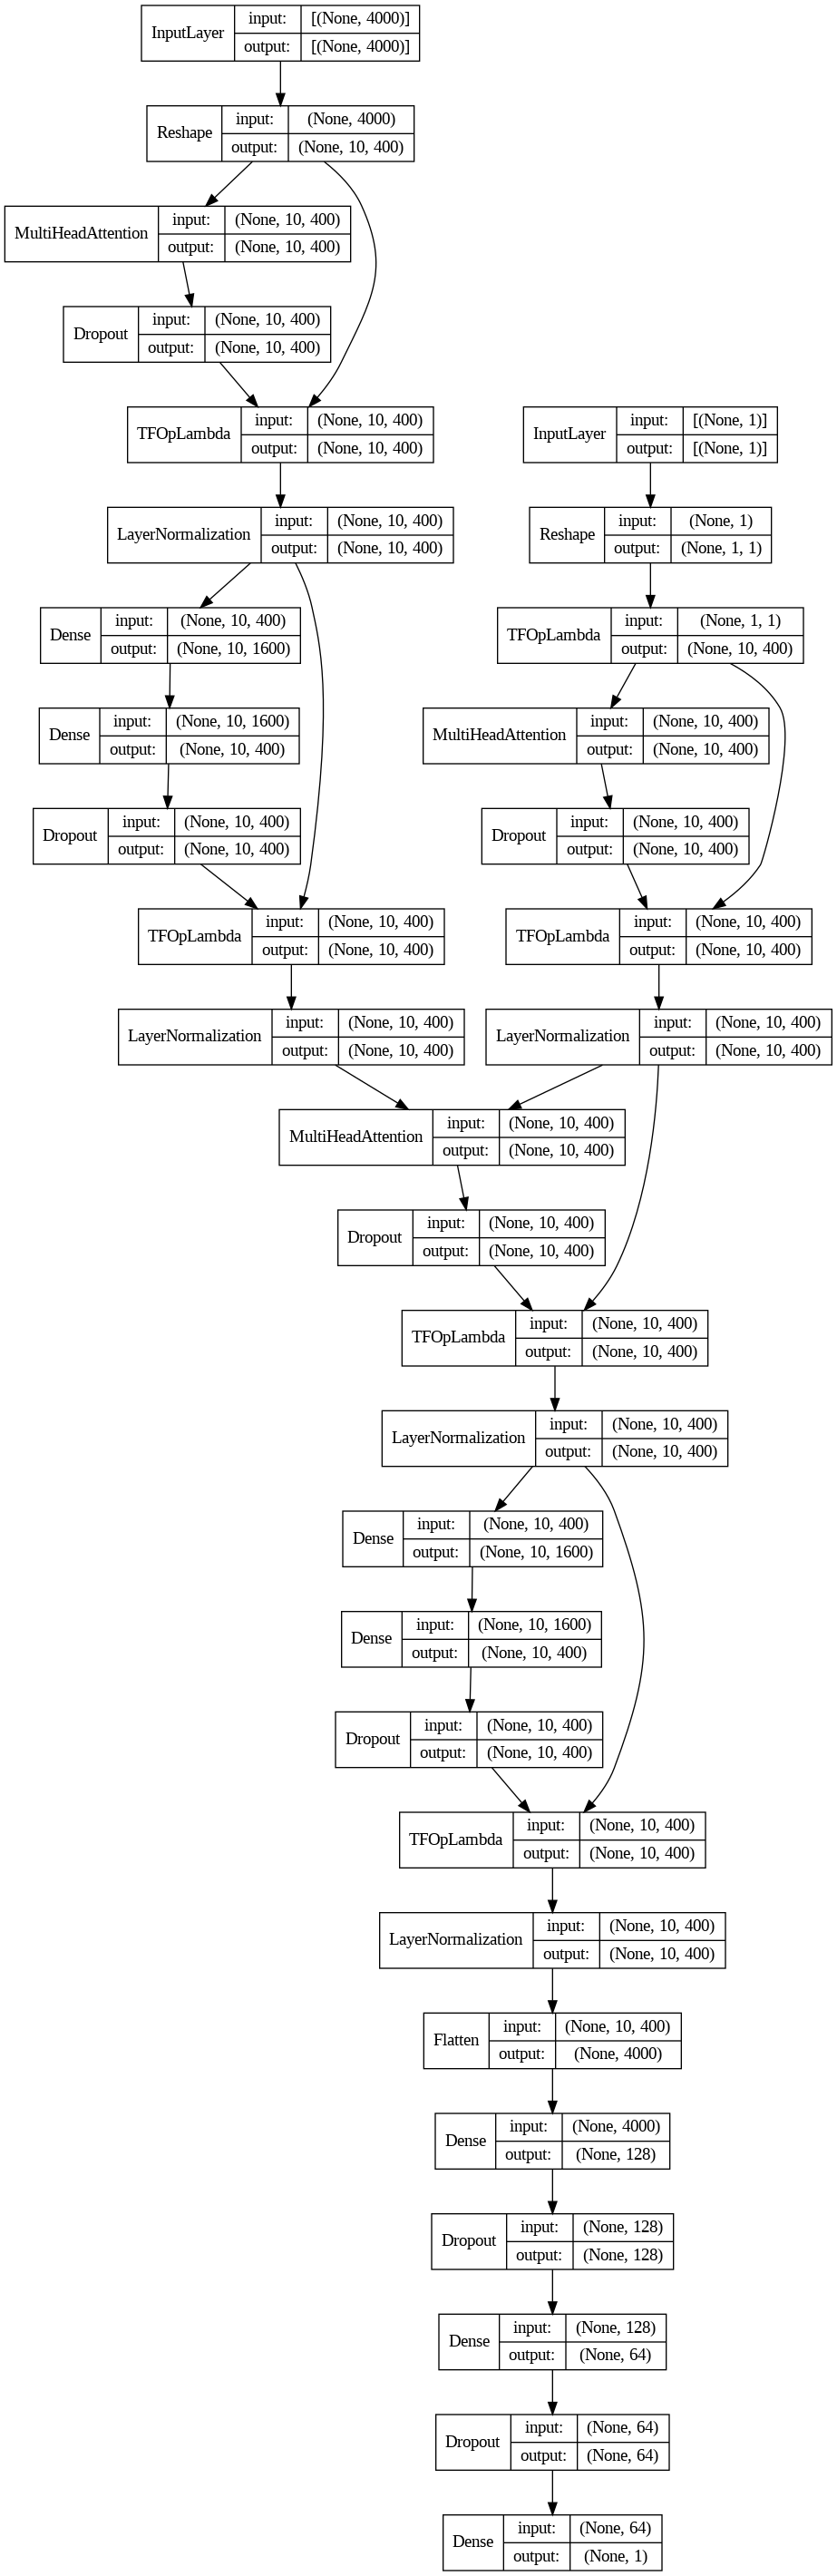

In [79]:
plot_model(model, show_shapes=True, show_layer_names=False)

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


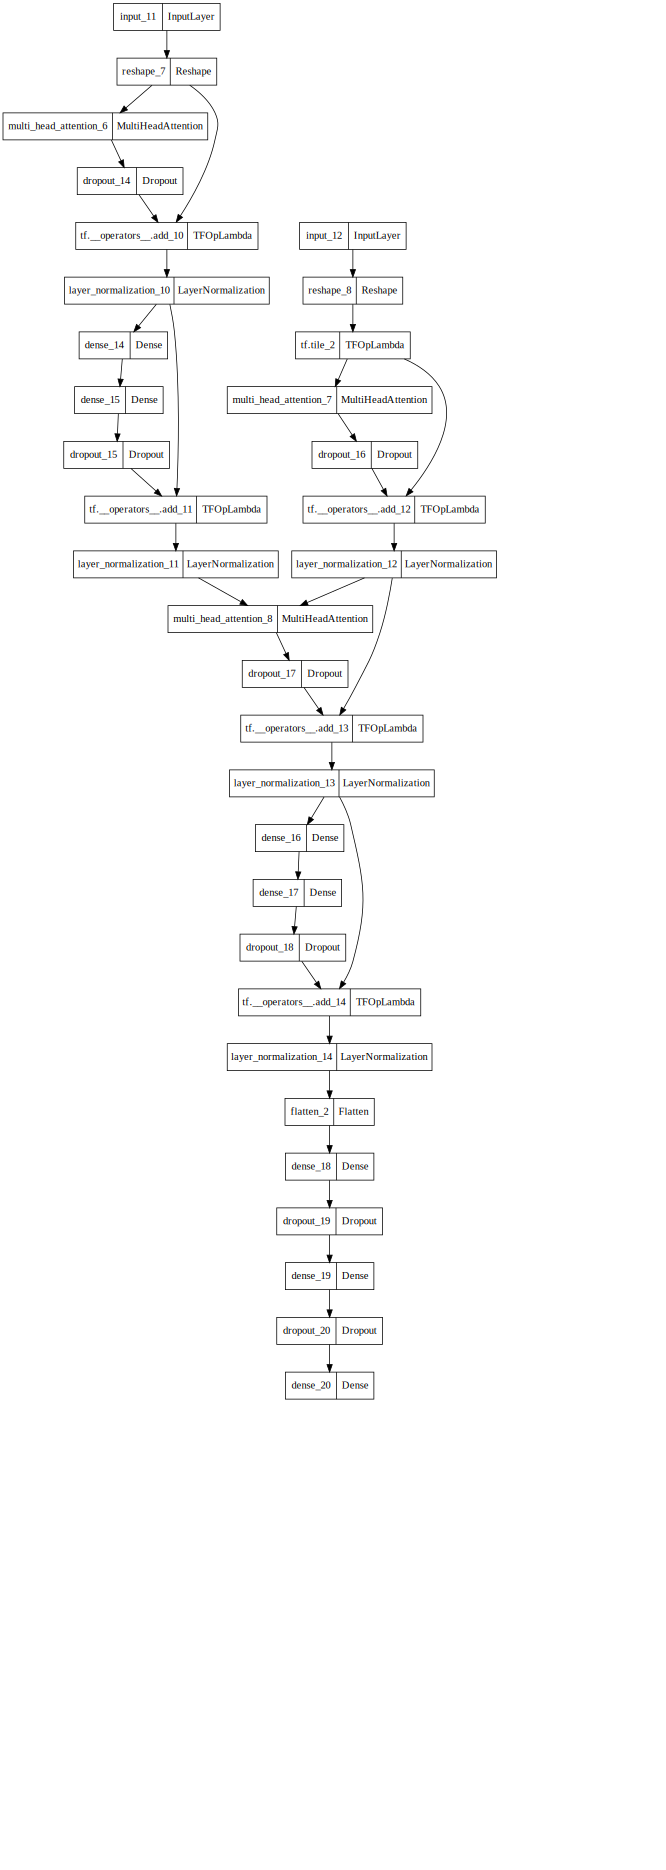

In [80]:
from IPython.display import SVG
from keras.utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))


In [98]:
x_train, x_test, y_train, y_test = train_test_split(DifferenceAcc_hist, Hz, train_size = TRAIN_SIZE, shuffle = True)
history = model.fit([x_train, y_train], y_train, batch_size=16, epochs=50, shuffle=True, validation_split=0.2)

Epoch 1/50
6/6 [==============================] - 2s 254ms/step - loss: 34.2323 - mean_squared_error: 34.2323 - val_loss: 7.6222 - val_mean_squared_error: 7.6222
Epoch 2/50
6/6 [==============================] - 1s 159ms/step - loss: 58.0692 - mean_squared_error: 58.0692 - val_loss: 11.1028 - val_mean_squared_error: 11.1028
Epoch 3/50
6/6 [==============================] - 1s 174ms/step - loss: 30.7812 - mean_squared_error: 30.7812 - val_loss: 33.5150 - val_mean_squared_error: 33.5150
Epoch 4/50
6/6 [==============================] - 1s 175ms/step - loss: 24.1458 - mean_squared_error: 24.1458 - val_loss: 8.9352 - val_mean_squared_error: 8.9352
Epoch 5/50
6/6 [==============================] - 1s 160ms/step - loss: 33.1501 - mean_squared_error: 33.1501 - val_loss: 42.7363 - val_mean_squared_error: 42.7363
Epoch 6/50
6/6 [==============================] - 1s 178ms/step - loss: 34.6735 - mean_squared_error: 34.6735 - val_loss: 10.7663 - val_mean_squared_error: 10.7663
Epoch 7/50
6/6 [====

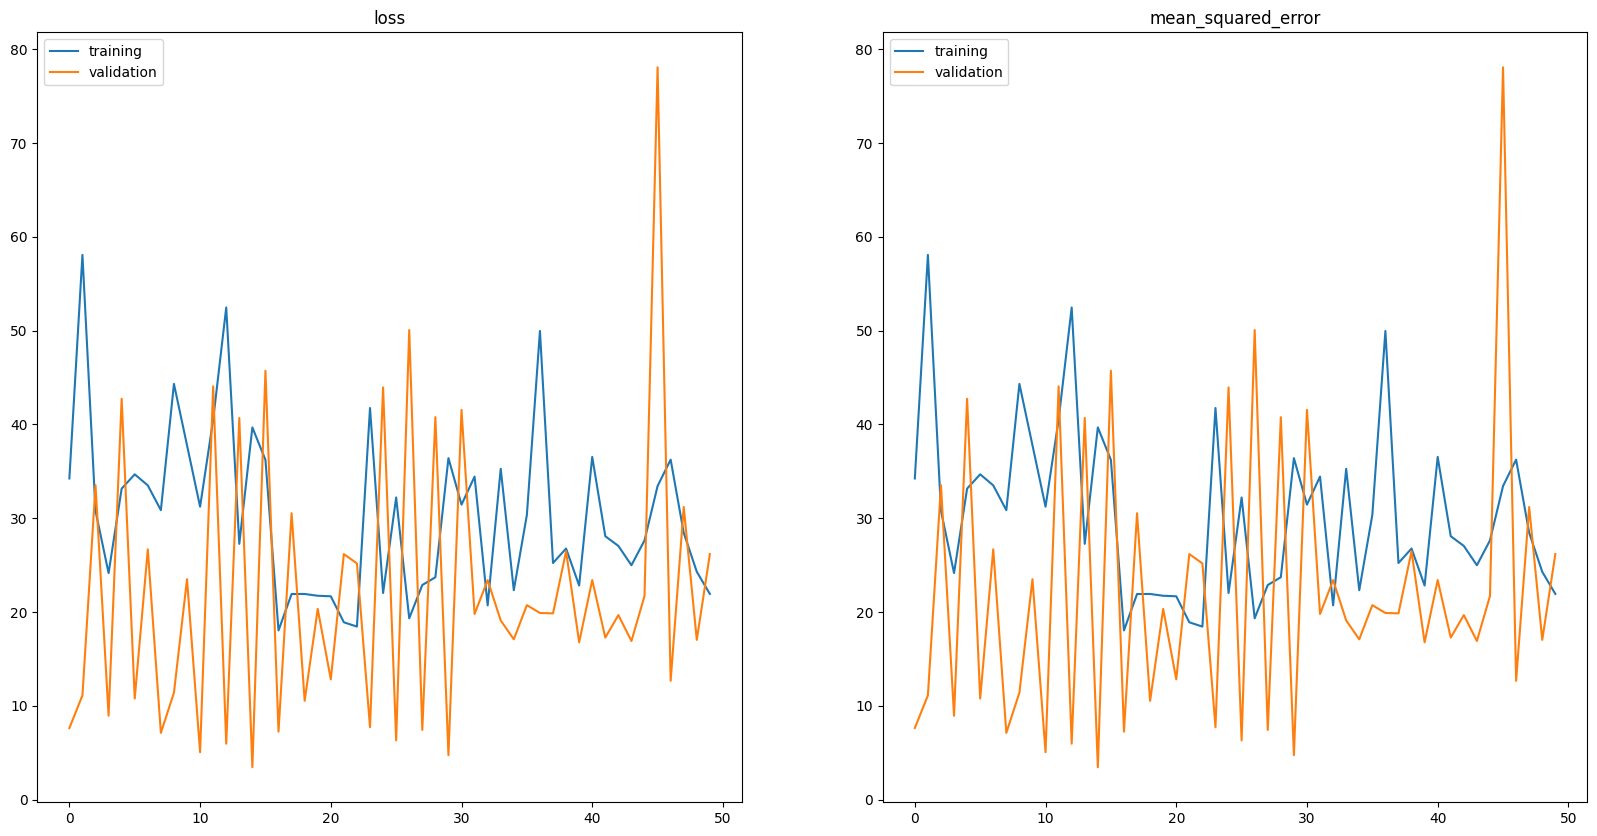

In [99]:
metrics = ['loss', 'mean_squared_error']  # 使用する評価関数を指定
 
plt.figure(figsize=(20, 10))  # グラフを表示するスペースを用意
 
for i in range(len(metrics)):
 
    metric = metrics[i]
 
    plt.subplot(1, 2, i+1)  # figureを1×2のスペースに分け、i+1番目のスペースを使う
    plt.title(metric)  # グラフのタイトルを表示
    
    plt_train = history.history[metric]  # historyから訓練データの評価を取り出す
    plt_test = history.history['val_' + metric]  # historyからテストデータの評価を取り出す
    
    plt.plot(plt_train, label='training')  # 訓練データの評価をグラフにプロット
    plt.plot(plt_test, label='validation')  # テストデータの評価をグラフにプロット
    plt.legend()  # ラベルの表示
    
plt.show()  # グラフの表示

In [85]:
y_pred = tf.cast(tf.clip_by_value(model.predict([x_test, y_test]), 20, 100), tf.int32)
mean_absolute_error(y_pred, y_test)

1/1 [==============================] - 0s 126ms/step


4.793103448275862

In [ ]:
#旧Transformer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#transformer regression
# Define the input shape
input_shape = (BINS,)

# Define the model
inputs = layers.Input(shape=input_shape)
x = layers.Reshape((100, 40))(inputs)
#y = layers.Reshape((100, 40))(inputs)
x = layers.MultiHeadAttention(num_heads=8, key_dim=64)(x, x)
#y = layers.MultiHeadAttention(num_heads=8, key_dim=64)(x, y)
#x = layers.Flatten()(y)
x = layers.Flatten()(x)
#x = layers.Dense(256, activation="relu")(x)
#x = layers.Dropout(0.1)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="relu")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.mean_squared_error,
    metrics=[keras.metrics.mean_squared_error],
)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#予測値をint型に限定
#y_pred = tf.cast(model.predict(x_test), tf.int32)
#予測値の範囲を限定
#y_pred = tf.clip_by_value(model.predict(x_test), 20, 100)

#予測値の型と範囲を限定
y_pred = tf.cast(tf.clip_by_value(model.predict(x_test), 20, 100), tf.int32)

#平均二乗誤差
mse = mean_squared_error(y_pred, y_test)

#二乗平均平方誤差
rmse = np.sqrt(mse)

#平均絶対誤差
mae = mean_absolute_error(y_pred, y_test)

#決定係数
r2 = r2_score(y_pred, y_test)

In [82]:
x_train, x_test, y_train, y_test = train_test_split(DifferenceAcc_hist, Hz, train_size = TRAIN_SIZE, shuffle = True)
model.fit([x_train, y_train], y_train, batch_size=16, epochs=50, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict([x_test, y_test]), 20, 100), tf.int32)
mean_absolute_error(y_pred, y_test)

Epoch 1/50
6/6 [==============================] - 1s 173ms/step - loss: 189.7249 - mean_squared_error: 189.7249 - val_loss: 68.5217 - val_mean_squared_error: 68.5217
Epoch 2/50
6/6 [==============================] - 1s 166ms/step - loss: 140.3996 - mean_squared_error: 140.3996 - val_loss: 73.2024 - val_mean_squared_error: 73.2024
Epoch 3/50
6/6 [==============================] - 1s 163ms/step - loss: 84.8082 - mean_squared_error: 84.8082 - val_loss: 72.3177 - val_mean_squared_error: 72.3177
Epoch 4/50
6/6 [==============================] - 1s 175ms/step - loss: 112.2231 - mean_squared_error: 112.2231 - val_loss: 112.1868 - val_mean_squared_error: 112.1868
Epoch 5/50
6/6 [==============================] - 1s 157ms/step - loss: 146.2117 - mean_squared_error: 146.2117 - val_loss: 149.1522 - val_mean_squared_error: 149.1522
Epoch 6/50
6/6 [==============================] - 1s 163ms/step - loss: 117.2091 - mean_squared_error: 117.2091 - val_loss: 90.1716 - val_mean_squared_error: 90.1716
Ep

3.4482758620689653

In [ ]:
#一連のやつ
Hz_and_filename = get_Hz_and_filename(path)
Hz_and_filename.sort(reverse=True)  #周波数の大きい順にソート
Hz, filename = divide_Hz_and_filename(Hz_and_filename)
Hz = np.array(Hz)

#使う変数を宣言
AccX, AccY, AccZ = [], [], []
ResultantAcc = []
DifferenceAcc_list = []

#各データセットからデータを読み込み静止区間を除去したものを二次元配列に格納
for i in filename:
    AccX, AccY, AccZ = get_acceleration(path+i)
    ResultantAcc.append(acc_to_remove_stationary_intervals(AccX, AccY, AccZ))

In [ ]:
#ヒストグラム作成
for i in range(len(ResultantAcc)):
    DifferenceAcc_list.append(calculate_differences_of_acceleration(ResultantAcc[i]))
DifferenceAcc_hist = create_histogram2(DifferenceAcc_list)

In [ ]:
#尖度
DifferenceAcc_kurtosis = np.zeros(len(DifferenceAcc_hist))
for i in range(len(DifferenceAcc_hist)):
    DifferenceAcc_kurtosis[i] = kurtosis(DifferenceAcc_hist[i])

#歪度
DifferenceAcc_skewness = np.zeros(len(DifferenceAcc_hist))
for i in range(len(DifferenceAcc_hist)):
    DifferenceAcc_skewness[i] = skew(DifferenceAcc_hist[i])

#分散
histogram_var = np.zeros(len(DifferenceAcc_list))
for i in range(len(DifferenceAcc_hist)):
    histogram_var[i] = np.var(DifferenceAcc_list[i])

In [ ]:
#X_newに尖度＋歪度+分散を連結したもの
X_new = np.concatenate((DifferenceAcc_kurtosis.reshape(-1, 1), DifferenceAcc_skewness.reshape(-1, 1), histogram_var.reshape(-1, 1)), axis=1)
#XはDifferenceAcc_hist+X_new
X = np.concatenate((DifferenceAcc_hist, X_new), axis=1)